# CNN on CIFAR-10 with Tensorflow

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import argparse
import sys
from tensorflow.python.keras import datasets
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import cv2

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## define the model

In [3]:
def deepnn(x):
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    x_image = tf.reshape(x, [-1, 32, 32, 3])

    # First convolutional layer - maps one color image to 32 feature maps.
    W_conv1 = weight_variable([3, 3, 3, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Second convolutional layer
    W_conv2 = weight_variable([3, 3, 32, 32])
    b_conv2 = bias_variable([32])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

    # Pooling layer - downsamples by 2X.
    h_pool1 = max_pool_2x2(h_conv2)

    # Third convolutional layer -- maps 32 feature maps to 64.
    W_conv3 = weight_variable([3, 3, 32, 64])
    b_conv3 = bias_variable([64])
    h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv3) + b_conv3)

    # Second pooling layer.
    h_pool2 = max_pool_2x2(h_conv3)

    # Fully connected layer 1 -- after 2 round of downsampling, our 32x32 image
    # is down to 8x8x64 feature maps -- maps this to 512 features.
    W_fc1 = weight_variable([8 * 8 * 64, 512])
    b_fc1 = bias_variable([512])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Dropout - controls the complexity of the model, prevents co-adaptation of
    # features.
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Fully connected layer 2 --  Map the 512 features to 10 classes, one for each digit
    W_fc2 = weight_variable([512, 10])
    b_fc2 = bias_variable([10])

    h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    y_conv = h_fc2
    return y_conv, keep_prob


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

## import data

In [4]:
# Import data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.int32)
y_train = np.reshape(y_train, [x_train.shape[0]])

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)
y_test = np.reshape(y_test, [y_test.shape[0]])


In [6]:
cifar_10_categories = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse", 8:"ship",9:"truck"}

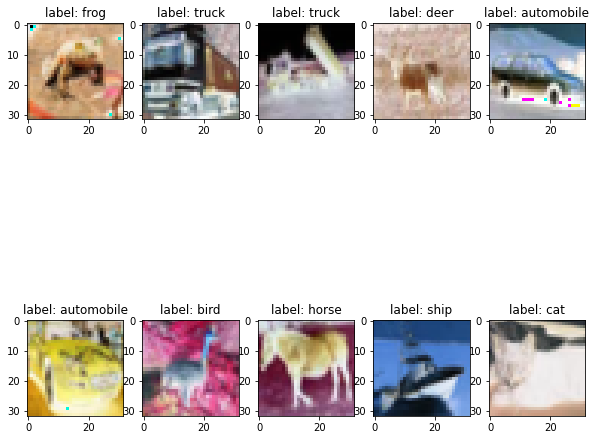

In [7]:
nrows, ncols = 2, 5  # array of sub-plots
figsize = [10, 10]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = (cv2.cvtColor(x_train[i] * 255, cv2.COLOR_BGR2RGB)).astype(np.uint8)
    axi.imshow(img)
    axi.set_title("label: "+ cifar_10_categories[int(y_train[i])])
plt.show()

## hyperparameters

In [8]:
batch_size = 20
learning_rate = 0.001
epochs = 10


## batch data

In [9]:
#train
train_num_iter = np.int(x_train.shape[0] / batch_size) * epochs
print("train_num_iter", train_num_iter)

# batch dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.repeat()
train_batched_dataset = train_dataset.batch(batch_size)

# create iterator
train_iterator = train_batched_dataset.make_initializable_iterator()
train_next_element, train_next_label = train_iterator.get_next()

#test
test_num_iter = np.int(x_test.shape[0]/ batch_size) * epochs
print("test_num_iter", test_num_iter)

# batch dataset
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.repeat()
test_batched_dataset = test_dataset.batch(batch_size)

# create iterator
test_iterator = test_batched_dataset.make_initializable_iterator()
test_next_element, test_next_label = test_iterator.get_next()


train_num_iter 25000
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
test_num_iter 5000


## training

In [10]:
# Build the graph for the deep net
logits, keep_prob = deepnn(train_next_element)
logits = tf.identity(logits, name='logits')

# loss
cost = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=train_next_label, weights=1.0))
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

 # Accuracy
prediction = tf.argmax(input=logits, axis=1, output_type=tf.int32)
correctones = tf.cast(tf.equal(prediction, train_next_label), dtype=tf.float32)
accuracy = tf.reduce_mean(correctones, name='accuracy')


tf.summary.scalar('loss', cost)
tf.summary.scalar('accuracy', accuracy)
tf.summary.histogram('histogram_loss', cost)
summary_op = tf.summary.merge_all()


writer = tf.summary.FileWriter('./graphs/convnet', tf.get_default_graph())

sess = tf.Session()
sess.run(train_iterator.initializer)
sess.run(tf.global_variables_initializer())
for i in range(train_num_iter):
    summary, _, loss, acc = sess.run([summary_op, optimizer, cost, accuracy], feed_dict={keep_prob:1.0})
    if i % 50 == 0:
        print('step %d, loss, %g, training accuracy %g' % (i, loss, acc))
    writer.add_summary(summary, i)
writer.close()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
step 0, loss, 992.863, training accuracy 0.05
step 50, loss, 8.47401, training accuracy 0.2
step 100, loss, 5.67597, training accuracy 0.2
step 150, loss, 3.59169, training accuracy 0.2
step 200, loss, 3.58881, training accuracy 0.2
step 250, loss, 2.71874, training accuracy 0.1
step 300, loss, 2.16106, training accuracy 0.3
step 350, loss, 2.11621, training accuracy 0.35
step 400, loss, 2.23824, training accuracy 0.25
step 450, loss, 2.21754, training accuracy 0.3
step 500, loss, 1.79445, training accuracy 0.4
step 550, loss, 1.99743, training accuracy 0.35
step 600, loss, 2.19479, training accuracy 0.2
step 650, loss, 2.41638, training accuracy 0.1
step 700, loss, 1.97634, training accuracy 0.25
step 750, loss, 2.2415, training accuracy 0.35
step 800, loss, 2.31796, training accuracy 0.05
step 850, loss, 2.14741, training accuracy 0.1
step 900, loss, 2.14566, training ac

step 8150, loss, 1.67249, training accuracy 0.55
step 8200, loss, 1.42362, training accuracy 0.5
step 8250, loss, 1.35443, training accuracy 0.55
step 8300, loss, 1.64407, training accuracy 0.4
step 8350, loss, 1.33802, training accuracy 0.6
step 8400, loss, 1.59597, training accuracy 0.35
step 8450, loss, 1.46305, training accuracy 0.4
step 8500, loss, 1.84925, training accuracy 0.35
step 8550, loss, 1.37095, training accuracy 0.4
step 8600, loss, 1.62287, training accuracy 0.4
step 8650, loss, 1.50131, training accuracy 0.5
step 8700, loss, 1.41376, training accuracy 0.55
step 8750, loss, 1.39074, training accuracy 0.55
step 8800, loss, 1.58048, training accuracy 0.35
step 8850, loss, 1.43918, training accuracy 0.55
step 8900, loss, 1.29831, training accuracy 0.5
step 8950, loss, 1.45605, training accuracy 0.55
step 9000, loss, 1.36719, training accuracy 0.55
step 9050, loss, 1.5529, training accuracy 0.5
step 9100, loss, 1.4393, training accuracy 0.35
step 9150, loss, 1.55375, train

step 16450, loss, 0.823171, training accuracy 0.6
step 16500, loss, 0.699231, training accuracy 0.75
step 16550, loss, 0.890053, training accuracy 0.7
step 16600, loss, 0.886547, training accuracy 0.65
step 16650, loss, 1.15611, training accuracy 0.55
step 16700, loss, 1.05338, training accuracy 0.7
step 16750, loss, 0.848696, training accuracy 0.7
step 16800, loss, 1.51476, training accuracy 0.55
step 16850, loss, 0.635648, training accuracy 0.85
step 16900, loss, 1.22672, training accuracy 0.6
step 16950, loss, 0.927847, training accuracy 0.65
step 17000, loss, 0.98648, training accuracy 0.7
step 17050, loss, 0.663195, training accuracy 0.65
step 17100, loss, 0.872961, training accuracy 0.75
step 17150, loss, 1.0355, training accuracy 0.6
step 17200, loss, 0.439335, training accuracy 0.85
step 17250, loss, 0.47513, training accuracy 0.8
step 17300, loss, 0.572713, training accuracy 0.8
step 17350, loss, 0.869276, training accuracy 0.7
step 17400, loss, 1.80858, training accuracy 0.25

step 24650, loss, 0.58467, training accuracy 0.8
step 24700, loss, 0.559166, training accuracy 0.75
step 24750, loss, 0.35319, training accuracy 0.85
step 24800, loss, 0.560739, training accuracy 0.8
step 24850, loss, 0.365772, training accuracy 0.85
step 24900, loss, 0.933813, training accuracy 0.6
step 24950, loss, 0.551094, training accuracy 0.8


## test

In [11]:
sess.run(test_iterator.initializer)
accuracy_history= []
loss_history= []
for i in range(test_num_iter):
    loss, acc = sess.run([cost, accuracy], feed_dict={keep_prob: 1.0})
    accuracy_history.append(acc)
    loss_history.append(loss)

In [12]:
import statistics

print("mean test loss: " + str(statistics.mean(loss_history)))
print("mean test accuracy_history: " + str(statistics.mean(accuracy_history)))

mean test loss: 0.7611086
mean test accuracy_history: 0.75548


##  show some predictions of one batch

In [13]:
_prediction,_label,acc, _correct_pred =  sess.run([prediction, test_next_label,accuracy,correctones], feed_dict={keep_prob: 1.0})

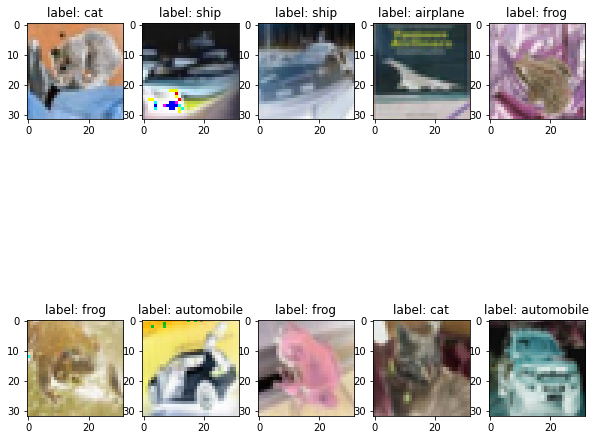

In [15]:
nrows, ncols = 2, 5  # array of sub-plots
figsize = [10, 10]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = (cv2.cvtColor(x_test[i] * 255, cv2.COLOR_BGR2RGB)).astype(np.uint8)
    axi.imshow(img)
    axi.set_title("label: "+ cifar_10_categories[int(y_test[i])])
plt.show()